In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec


def get_vcf_header(datafile):
    for line in open(datafile).readlines():        
        if line[0:2] == '##':
            continue
        else:
            header = line[1:].rstrip().split('\t')
            break
    return(header)

def get_haplotype_matrix(vcfdatafile, resultsfile=None):
    header = get_vcf_header(vcfdatafile)
    rawdata = pd.read_csv(vcfdatafile, sep='\t', comment='#', names=header)
    sampdata = rawdata.iloc[:, 9:]
    a1 = sampdata.applymap(lambda x: int(x[0]))
    i1 = [(x, 1) for x in sampdata.columns]
    i1 = pd.MultiIndex.from_tuples(i1, names=['sample', 'allele'])
    a1.columns = i1
    a2 = sampdata.applymap(lambda x: int(x[2]))
    i2 = [(x, 2) for x in sampdata.columns]
    i2 = pd.MultiIndex.from_tuples(i2, names=['sample', 'allele'])
    a2.columns = i2
    vardata = rawdata.iloc[:, 0:8]
    ind = [('snpvalues', x) for x in vardata.columns]
    ind = pd.MultiIndex.from_tuples(ind, names=['sample', 'allele'])
    vardata.columns = ind
    results = pd.concat([vardata, a1, a2], axis=1)
    index = list(results.columns)
    index = pd.MultiIndex.from_tuples(index, names=['sample', 'allele'])
    results.columns = index
    if resultsfile is not None:
        results.to_csv(resultsfile, sep='\t')
    return(results)

from fastcluster import linkage
from scipy.cluster.hierarchy import optimal_leaf_ordering
from scipy.spatial.distance import pdist
import seaborn as sns
from scipy.cluster.hierarchy import leaves_list
from sklearn.cluster import KMeans

from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

figuredir = '../../figures'
if not os.path.exists(figuredir):
    os.mkdir(figuredir)

In [2]:
import sklearn
sklearn.__version__

'0.21.3'

## Make temporary directory to hold haplotype data

In [22]:
tmpdir = '../../data/tmp/'
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)

largedir = '../../data/tmp/LARGE'
if not os.path.exists(largedir):
    os.mkdir(largedir)
    
vcfdata = '../../data/tmp/LARGE/vcf'
if not os.path.exists(vcfdata):
    os.mkdir(vcfdata)

## Download and subset variants from post2016 data (SL + NG) phased with EAGLE and AGR reference panel

In [4]:
remotedir = 'gs://popgen-gwas/data/genotype/merge/Imputed_VCF_20220113'
cmd = 'gsutil -m cp {remote}/22* {local}'.format(remote=remotedir, local=vcfdata)
print(cmd)
!{cmd}

gsutil -m cp gs://popgen-gwas/data/genotype/merge/Imputed_VCF_20220113/22* ../../data/tmp/LARGE/vcf
Copying gs://popgen-gwas/data/genotype/merge/Imputed_VCF_20220113/22.vcf.gz...
Copying gs://popgen-gwas/data/genotype/merge/Imputed_VCF_20220113/22.vcf.gz.csi...
\ [2/2 files][  1.1 GiB/  1.1 GiB] 100% Done 101.6 MiB/s ETA 00:00:00           
Operation completed over 2 objects/1.1 GiB.                                      


## Defining boundaries
- used the 1000G region defined in https://royalsocietypublishing.org/doi/full/10.1098/rstb.2011.0299


In [23]:
hg18_left = 32200000
hg18_right = 32800000

from pyliftover import LiftOver
lo = LiftOver('hg18', 'hg19')
print(lo.convert_coordinate('chr22', hg18_left))
print(lo.convert_coordinate('chr22', hg18_right))

start = lo.convert_coordinate('chr22', hg18_left)[0][1]
end = lo.convert_coordinate('chr22', hg18_right)[0][1]
print(start, end)

[('chr22', 33870000, '+', 3320958047)]
[('chr22', 34470000, '+', 3320958047)]
33870000 34470000


In [24]:
chrom=22
mafthresh = .01
maxthresh = 1-mafthresh

infn = '{vdir}/22.vcf.gz'.format(vdir=vcfdata)
outfn = infn.replace('vcf.gz', '%d_to_%d.maf_1e-2.vcf' % (start, end))
outfn

'../../data/tmp/LARGE/vcf/22.33870000_to_34470000.maf_1e-2.vcf'

In [27]:
resfn = outfn.replace('.vcf', '.txt')

In [28]:
hapmatrix = pd.read_csv(resfn, sep='\t', header=[0,1])

In [29]:
hapmatrix.head()

sample snpvalues                                             \
  allele     CHROM       POS           ID REF ALT QUAL FILTER   
0      0        22  33870122   rs73409033   A   G    .   PASS   
1      1        22  33870673    rs4821151   C   G    .   PASS   
2      2        22  33870905    rs8136515   C   T    .   PASS   
3      3        22  33871234  rs116682359   C   T    .   PASS   
4      4        22  33871410  rs541559730   A   T    .   PASS   

                                                     WG0284565-DNA_A02_G-5231  \
                                                INFO                        1   
0  RefPanelAF=0.0109968;AN=11110;AC=197;INFO=0.95...                        0   
1  RefPanelAF=0.288741;AN=11110;AC=4180;INFO=0.99...                        0   
2  RefPanelAF=0.0216909;AN=11110;AC=212;INFO=0.85...                        0   
3  RefPanelAF=0.00373285;AN=11110;AC=170;INFO=0.9...                        0   
4  RefPanelAF=0.018866;AN=11110;AC=218;INFO=0.989288                        0   

   ... Winter2013_SM-298E9 Winter2013_SM-298D9 Winter2013_SM-298D3  \
   ...                   2                   2                   2   
0  ...                   0                   0                   0   
1  ...                   1                   0                   0   
2  ...                   0                   1                   0   
3  ...                   0                   0                   0   
4  ...                   0                   0                   0   

  Winter2013_SM-298DO Winter2013_SM-298CO Winter2013_SM-298E1  \
                    2                   2                   2   
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

  Winter2013_SM-298CT Winter2013_SM-298DJ Winter2013_SM-298CS  \
                    2                   2                   2   
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

  Winter2013_SM-298DH  
                    2  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 11119 columns]

In [30]:
index = hapmatrix['snpvalues'].apply(lambda x: '%d:%d[b37]%s,%s' % (x['CHROM'], x['POS'], x['REF'], x['ALT']), axis=1)
hapmatrix.index = index

In [31]:
hapmatrix.head()

sample snpvalues                                      \
                    allele     CHROM       POS           ID REF ALT QUAL   
22:33870122[b37]A,G      0        22  33870122   rs73409033   A   G    .   
22:33870673[b37]C,G      1        22  33870673    rs4821151   C   G    .   
22:33870905[b37]C,T      2        22  33870905    rs8136515   C   T    .   
22:33871234[b37]C,T      3        22  33871234  rs116682359   C   T    .   
22:33871410[b37]A,T      4        22  33871410  rs541559730   A   T    .   

                                                                               \
                    FILTER                                               INFO   
22:33870122[b37]A,G   PASS  RefPanelAF=0.0109968;AN=11110;AC=197;INFO=0.95...   
22:33870673[b37]C,G   PASS  RefPanelAF=0.288741;AN=11110;AC=4180;INFO=0.99...   
22:33870905[b37]C,T   PASS  RefPanelAF=0.0216909;AN=11110;AC=212;INFO=0.85...   
22:33871234[b37]C,T   PASS  RefPanelAF=0.00373285;AN=11110;AC=170;INFO=0.9...   
22:33871410[b37]A,T   PASS  RefPanelAF=0.018866;AN=11110;AC=218;INFO=0.989288   

                    WG0284565-DNA_A02_G-5231  ... Winter2013_SM-298E9  \
                                           1  ...                   2   
22:33870122[b37]A,G                        0  ...                   0   
22:33870673[b37]C,G                        0  ...                   1   
22:33870905[b37]C,T                        0  ...                   0   
22:33871234[b37]C,T                        0  ...                   0   
22:33871410[b37]A,T                        0  ...                   0   

                    Winter2013_SM-298D9 Winter2013_SM-298D3  \
                                      2                   2   
22:33870122[b37]A,G                   0                   0   
22:33870673[b37]C,G                   0                   0   
22:33870905[b37]C,T                   1                   0   
22:33871234[b37]C,T                   0                   0   
22:33871410[b37]A,T                   0                   0   

                    Winter2013_SM-298DO Winter2013_SM-298CO  \
                                      2                   2   
22:33870122[b37]A,G                   0                   0   
22:33870673[b37]C,G                   0                   0   
22:33870905[b37]C,T                   0                   0   
22:33871234[b37]C,T                   0                   0   
22:33871410[b37]A,T                   0                   0   

                    Winter2013_SM-298E1 Winter2013_SM-298CT  \
                                      2                   2   
22:33870122[b37]A,G                   0                   0   
22:33870673[b37]C,G                   0                   0   
22:33870905[b37]C,T                   0                   0   
22:33871234[b37]C,T                   0                   0   
22:33871410[b37]A,T                   0                   0   

                    Winter2013_SM-298DJ Winter2013_SM-298CS  \
                                      2                   2   
22:33870122[b37]A,G                   0                   0   
22:33870673[b37]C,G                   0                   0   
22:33870905[b37]C,T                   0                   0   
22:33871234[b37]C,T                   0                   0   
22:33871410[b37]A,T                   0                   0   

                    Winter2013_SM-298DH  
                                      2  
22:33870122[b37]A,G                   0  
22:33870673[b37]C,G                   0  
22:33870905[b37]C,T                   0  
22:33871234[b37]C,T                   0  
22:33871410[b37]A,T                   0  

[5 rows x 11119 columns]

In [12]:
psams = ! gsutil ls gs://popgen-gwas/data/analysis/results_20220201/*/raw_data/*.psam
psams

['gs://popgen-gwas/data/analysis/results_20220201/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220107.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.psam',
 'gs://popgen-gwas/data/analysis/results_20220201/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220107.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.unrelated.psam',
 'gs://popgen-gwas/data/analysis/results_20220201/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220107.Deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.psam',
 'gs://popgen-gwas/data/analysis/results_20220201/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOm

In [13]:
psams = [x for x in psams if 'unrelated' not in x]
sampstokeep = []
for p in psams:
    sampstokeep.append(pd.read_csv(p, sep='\t'))
    
sampstokeep = pd.concat(sampstokeep, axis=0)
sampstokeep.head()

,#FID,IID,PAT,MAT,SEX,PHENO1
0,0,WG0284582-DNA_A05_SM-87W5V,0,0,2,2
1,0,WG0284582-DNA_A06_SM-NEIDU,0,0,2,2
2,0,WG0284582-DNA_A11_SM-5X7Q1,0,0,2,2
3,0,WG0284582-DNA_D05_SM-45CMW,0,0,2,2
4,0,WG0284582-DNA_D06_SM-656GK,0,0,1,2


In [14]:
sampstokeep['IID'].value_counts().head()

March2012_SM-2987O         1
Winter2013_F-NG-NC-242F    1
Fall2013_SM-29824          1
Winter2014_C-0621_1        1
Winter2013_F-NG-C-95M      1
Name: IID, dtype: int64

In [15]:
tokeep = ['snpvalues'] + list(sampstokeep['IID'])

In [16]:
hapmatrix.head()

sample snpvalues                                      \
                    allele     CHROM       POS           ID REF ALT QUAL   
22:33870122[b37]A,G      0        22  33870122   rs73409033   A   G    .   
22:33870673[b37]C,G      1        22  33870673    rs4821151   C   G    .   
22:33870905[b37]C,T      2        22  33870905    rs8136515   C   T    .   
22:33871234[b37]C,T      3        22  33871234  rs116682359   C   T    .   
22:33871410[b37]A,T      4        22  33871410  rs541559730   A   T    .   

                                                                               \
                    FILTER                                               INFO   
22:33870122[b37]A,G   PASS  RefPanelAF=0.0109968;AN=11110;AC=197;INFO=0.95...   
22:33870673[b37]C,G   PASS  RefPanelAF=0.288741;AN=11110;AC=4180;INFO=0.99...   
22:33870905[b37]C,T   PASS  RefPanelAF=0.0216909;AN=11110;AC=212;INFO=0.85...   
22:33871234[b37]C,T   PASS  RefPanelAF=0.00373285;AN=11110;AC=170;INFO=0.9...   
22:33871410[b37]A,T   PASS  RefPanelAF=0.018866;AN=11110;AC=218;INFO=0.989288   

                    WG0284565-DNA_A02_G-5231  ... Winter2013_SM-298E9  \
                                           1  ...                   2   
22:33870122[b37]A,G                        0  ...                   0   
22:33870673[b37]C,G                        0  ...                   1   
22:33870905[b37]C,T                        0  ...                   0   
22:33871234[b37]C,T                        0  ...                   0   
22:33871410[b37]A,T                        0  ...                   0   

                    Winter2013_SM-298D9 Winter2013_SM-298D3  \
                                      2                   2   
22:33870122[b37]A,G                   0                   0   
22:33870673[b37]C,G                   0                   0   
22:33870905[b37]C,T                   1                   0   
22:33871234[b37]C,T                   0                   0   
22:33871410[b37]A,T                   0                   0   

                    Winter2013_SM-298DO Winter2013_SM-298CO  \
                                      2                   2   
22:33870122[b37]A,G                   0                   0   
22:33870673[b37]C,G                   0                   0   
22:33870905[b37]C,T                   0                   0   
22:33871234[b37]C,T                   0                   0   
22:33871410[b37]A,T                   0                   0   

                    Winter2013_SM-298E1 Winter2013_SM-298CT  \
                                      2                   2   
22:33870122[b37]A,G                   0                   0   
22:33870673[b37]C,G                   0                   0   
22:33870905[b37]C,T                   0                   0   
22:33871234[b37]C,T                   0                   0   
22:33871410[b37]A,T                   0                   0   

                    Winter2013_SM-298DJ Winter2013_SM-298CS  \
                                      2                   2   
22:33870122[b37]A,G                   0                   0   
22:33870673[b37]C,G                   0                   0   
22:33870905[b37]C,T                   0                   0   
22:33871234[b37]C,T                   0                   0   
22:33871410[b37]A,T                   0                   0   

                    Winter2013_SM-298DH  
                                      2  
22:33870122[b37]A,G                   0  
22:33870673[b37]C,G                   0  
22:33870905[b37]C,T                   0  
22:33871234[b37]C,T                   0  
22:33871410[b37]A,T                   0  

[5 rows x 11119 columns]

In [17]:
hapmatrix_dedup = hapmatrix.loc[:,hapmatrix.columns.get_level_values(0).isin(tokeep)]

## Investigate haplotype clustering

In [18]:
hapmatrix_dedup.iloc[:,8:].head()

,WG0284565-DNA_A08_G-7030,WG0284565-DNA_A09_G-7022,WG0284565-DNA_B08_G-7260,WG0284565-DNA_B10_G-7140,WG0284565-DNA_E08_G-6835,WG0284565-DNA_E11_G-7046,WG0284565-DNA_F11_G-7254,WG0284565-DNA_G09_G-7107,WG0284565-DNA_G11_G-7218,WG0284565-DNA_G12_G-7086,...,Winter2013_SM-298E9,Winter2013_SM-298D9,Winter2013_SM-298D3,Winter2013_SM-298DO,Winter2013_SM-298CO,Winter2013_SM-298E1,Winter2013_SM-298CT,Winter2013_SM-298DJ,Winter2013_SM-298CS,Winter2013_SM-298DH
,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
"22:33870122[b37]A,G",0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"22:33870673[b37]C,G",0,0,1,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
"22:33870905[b37]C,T",0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
"22:33871234[b37]C,T",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"22:33871410[b37]A,T",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
info = hapmatrix_dedup['snpvalues']
allele_calls = hapmatrix_dedup.iloc[:, 8:]

In [20]:
allele_calls.head()

,WG0284565-DNA_A08_G-7030,WG0284565-DNA_A09_G-7022,WG0284565-DNA_B08_G-7260,WG0284565-DNA_B10_G-7140,WG0284565-DNA_E08_G-6835,WG0284565-DNA_E11_G-7046,WG0284565-DNA_F11_G-7254,WG0284565-DNA_G09_G-7107,WG0284565-DNA_G11_G-7218,WG0284565-DNA_G12_G-7086,...,Winter2013_SM-298E9,Winter2013_SM-298D9,Winter2013_SM-298D3,Winter2013_SM-298DO,Winter2013_SM-298CO,Winter2013_SM-298E1,Winter2013_SM-298CT,Winter2013_SM-298DJ,Winter2013_SM-298CS,Winter2013_SM-298DH
,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
"22:33870122[b37]A,G",0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"22:33870673[b37]C,G",0,0,1,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
"22:33870905[b37]C,T",0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
"22:33871234[b37]C,T",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"22:33871410[b37]A,T",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
resfn.replace('.txt', '.clean.txt')

'../../data/tmp/LARGE/vcf/22.33870000_to_34470000.maf_1e-2.clean.txt'

In [22]:
allele_calls.to_csv(resfn.replace('.txt', '.clean.txt'), sep='\t')

In [23]:
maf = allele_calls.mean(axis=1)
ind = maf>.5
maf.loc[ind] = 1-maf.loc[ind]

In [24]:
allele_calls_05 = allele_calls.loc[maf>.05, :]

In [25]:
dist_pre = pdist(allele_calls_05.T, metric='hamming')
Zpre = linkage(dist_pre, method='single', preserve_input=True)
Zoptpre = optimal_leaf_ordering(Zpre, dist_pre)
ordering = leaves_list(Zoptpre)
allele_calls_05_ordered = allele_calls_05.iloc[:,ordering].T

Text(0, 0.5, 'Haplotype')

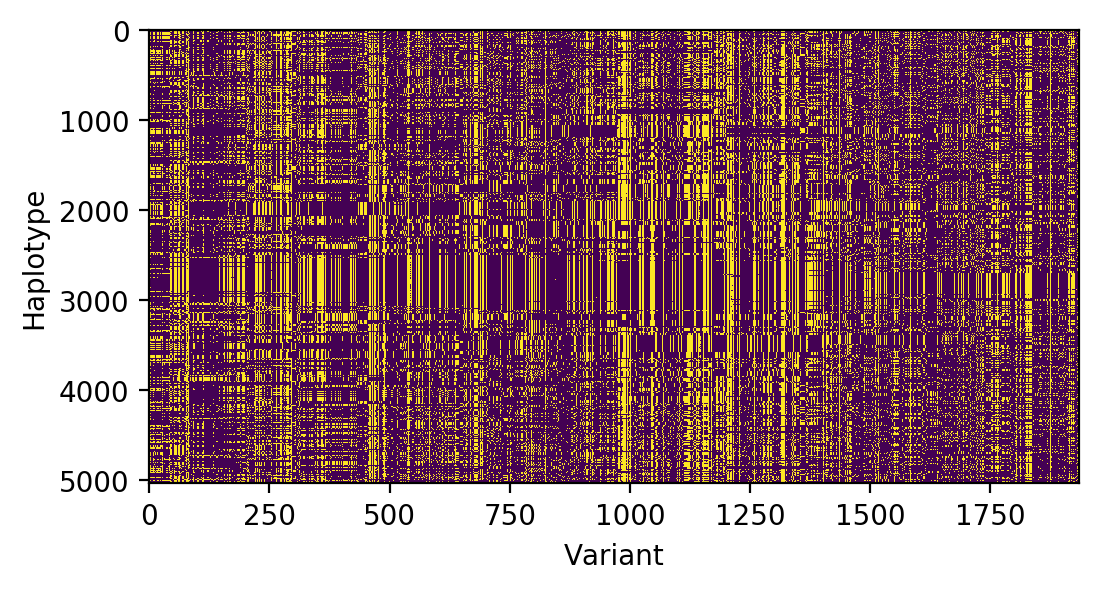

In [26]:
(fig,ax) = plt.subplots(1,1, figsize=(6,3), dpi=200)

ax.imshow(allele_calls_05_ordered,interpolation='none',aspect='auto',
                                          origin='upper')
ax.set_xlabel('Variant')
ax.set_ylabel('Haplotype')

In [27]:
allele_calls_05_2 = allele_calls_05.copy()

In [28]:
dist_pre = pdist(allele_calls_05_2.T, metric='hamming')
Zpre = linkage(dist_pre, method='single', preserve_input=True)
Zoptpre = optimal_leaf_ordering(Zpre, dist_pre)
orderingpre = leaves_list(Zoptpre)
allele_calls_05_2_ordered = allele_calls_05_2.iloc[:,orderingpre].T

Text(0, 0.5, 'Haplotype')

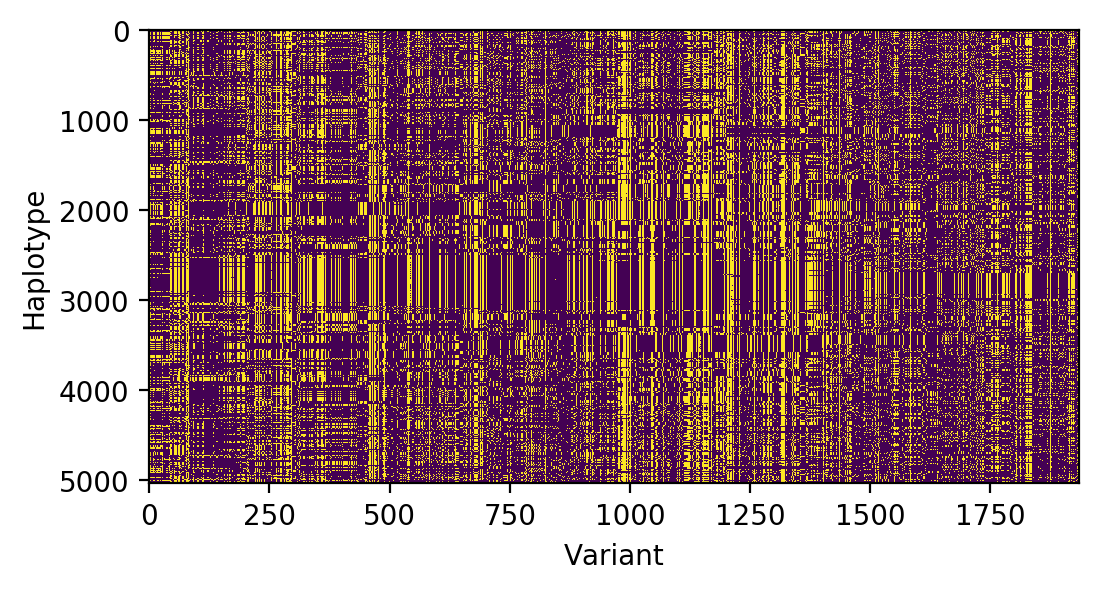

In [29]:
(fig,ax) = plt.subplots(1,1, figsize=(6,3), dpi=200)

ax.imshow(allele_calls_05_2_ordered,interpolation='none',aspect='auto',
                                          origin='upper')
ax.set_xlabel('Variant')
ax.set_ylabel('Haplotype')

## Run KMeans clustering

In [30]:
allele_calls_05_2.tail()

,WG0284565-DNA_A08_G-7030,WG0284565-DNA_A09_G-7022,WG0284565-DNA_B08_G-7260,WG0284565-DNA_B10_G-7140,WG0284565-DNA_E08_G-6835,WG0284565-DNA_E11_G-7046,WG0284565-DNA_F11_G-7254,WG0284565-DNA_G09_G-7107,WG0284565-DNA_G11_G-7218,WG0284565-DNA_G12_G-7086,...,Winter2013_SM-298E9,Winter2013_SM-298D9,Winter2013_SM-298D3,Winter2013_SM-298DO,Winter2013_SM-298CO,Winter2013_SM-298E1,Winter2013_SM-298CT,Winter2013_SM-298DJ,Winter2013_SM-298CS,Winter2013_SM-298DH
,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
"22:34469348[b37]G,A",0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
"22:34469447[b37]T,C",0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
"22:34469564[b37]G,A",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
"22:34469674[b37]G,C",0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
"22:34469959[b37]A,G",1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [31]:
kmod = KMeans(n_clusters=2, random_state=1)
kres = kmod.fit(allele_calls_05_2.T)

vc = pd.Series(kres.labels_).value_counts()
if vc.loc[0]<vc.loc[1]:
    labels = 1-kres.labels_
else:
    labels = kres.labels_

allele_calls_05_2_labels = pd.Series(labels, index=allele_calls_05_2.columns)    
vc = pd.Series(allele_calls_05_2_labels).value_counts().sort_index()



figrat = vc.div(vc.sum())
figrat = list(figrat)[::-1]
figrat

[0.21357681619690352, 0.7864231838030965]

In [32]:
X = allele_calls_05_2.loc[:,allele_calls_05_2_labels==1].T
dist = pdist(X, metric='hamming')
Z = linkage(dist, method='single', preserve_input=True)
Zopt = optimal_leaf_ordering(Z, dist)
ordering = leaves_list(Zopt)
X_ordered_top = X.iloc[ordering,:]

In [33]:
X = allele_calls_05_2.loc[:,allele_calls_05_2_labels==0].T
dist = pdist(X, metric='hamming')
Z = linkage(dist, method='single', preserve_input=True)
Zopt = optimal_leaf_ordering(Z, dist)
ordering = leaves_list(Zopt)
X_ordered_bot = X.iloc[ordering,:]

In [34]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

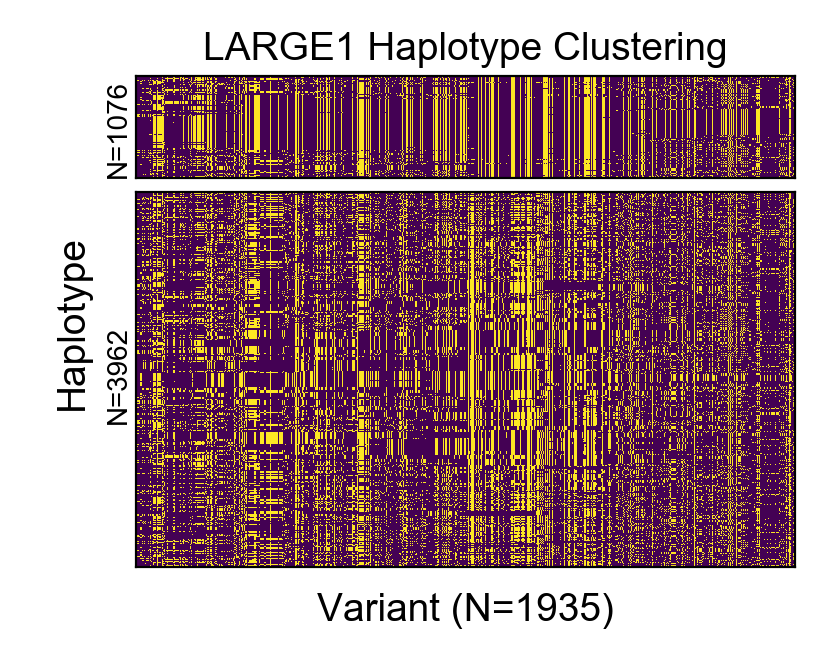

In [35]:


width = 5
height = 4
fig = plt.figure(figsize=(width,height), dpi=200)
spec2 = gridspec.GridSpec(ncols=2, nrows=4, figure=fig,
                         width_ratios=[width*.15, width*.85],
                         height_ratios=[.3, figrat[0]*3.4, figrat[1]*3.4, .3],
                         hspace=.1, wspace=0)

tit_ax = fig.add_subplot(spec2[0, 1])
ylab_ax = fig.add_subplot(spec2[1:3, 0])
top_hm_ax = fig.add_subplot(spec2[1, 1])
bot_hm_ax = fig.add_subplot(spec2[2, 1])
xlab_ax = fig.add_subplot(spec2[3, 1])
xlab_ax.axis('off')
tit_ax.axis('off')
ylab_ax.axis('off')
ylab_ax.set_ylim([0,1])


lab_fontsize = 14


top_hm_ax.imshow(X_ordered_top,interpolation='none',aspect='auto',
                                          origin='upper', rasterized=True)

top_hm_ax.set_xticks([])
top_hm_ax.set_yticks([])


bot_hm_ax.imshow(X_ordered_bot,interpolation='none',aspect='auto',
                                          origin='upper', rasterized=True)

bot_hm_ax.set_yticks([])
bot_hm_ax.set_xticks([])


tit_ax.text(.5, .3, 'LARGE1 Haplotype Clustering', ha='center', va='center',
           fontsize=lab_fontsize)
xlab_ax.text(.5, .3, 'Variant (N=%d)' % X_ordered_bot.shape[1], ha='center', va='center', fontsize=lab_fontsize)
ylab_ax.set_ylim([0,1])
ylab_ax.text(0.3, .5, 'Haplotype', ha='left', va='center', rotation=90,
             fontsize=lab_fontsize)

ylab_ax.text(.85, figrat[1]/2, 'N=%d' % vc[0], va='center', ha='center', rotation=90)
ylab_ax.text(.85, figrat[1] + (figrat[0]/2), 'N=%d' % vc[1], va='center', ha='center', rotation=90)

outfn = os.path.join(figuredir, 'Haplotype_Clustergram.pdf')
fig.savefig(outfn, bbox_inches='tight')
outfn = os.path.join(figuredir, 'Haplotype_Clustergram.png')
fig.savefig(outfn, bbox_inches='tight')

In [36]:
hapstatus = pd.DataFrame(allele_calls_05_2_labels, columns=['IDV_KMeans_Clustering'])
hapstatus['Sample'] = hapstatus.index.get_level_values(0)
hapstatus.head()

,,IDV_KMeans_Clustering,Sample
WG0284565-DNA_A08_G-7030,1,0,WG0284565-DNA_A08_G-7030
WG0284565-DNA_A09_G-7022,1,0,WG0284565-DNA_A09_G-7022
WG0284565-DNA_B08_G-7260,1,0,WG0284565-DNA_B08_G-7260
WG0284565-DNA_B10_G-7140,1,1,WG0284565-DNA_B10_G-7140
WG0284565-DNA_E08_G-6835,1,0,WG0284565-DNA_E08_G-6835


In [37]:
hapgenotype_calls = hapstatus.groupby('Sample')['IDV_KMeans_Clustering'].sum()
hapgenotype_calls = pd.DataFrame(hapgenotype_calls)
hapgenotype_calls.head()

,IDV_KMeans_Clustering
Sample,
Fall2013_SM-29811,1
Fall2013_SM-29812,0
Fall2013_SM-29813,1
Fall2013_SM-29817,2
Fall2013_SM-2981D,0


In [38]:
phenofn = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/preANDpost2016_Merged_Complete_Metadata_WithAge_20210818.tsv'
phenoinfo = pd.read_csv(phenofn, sep='\t')
phenoinfo.index = phenoinfo['Full_IID']
phenoinfo.head()

,Full_IID,Genotype_Sex,ID_Reformat,SampleType,sex,Disease,ISTH_SandR_Key,KGH_Survivor_Key,KGH_AcuteLassa_Key,KGH_AcuteEbola_Key,...,Batch,Country,Sex_Discrepant,Sex_Discrepant_Notes,Status,Clean_HLA_ID,Epoch,Array,CollectionEpoch,Age
Full_IID,,,,,,,,,,,,,,,,,,,,,
July2014NG_SM-6C4M9,July2014NG_SM-6C4M9,1,SM-6C4M9,SuspectedLassaNG,1,Lassa,NaN,NaN,NaN,NaN,...,July2014NG,NG,False,NaN,Passes QC,NaN,Pre2016,Omni_25M_B,Pre2016,30.0
July2014NG_SM-4XBS9,July2014NG_SM-4XBS9,2,SM-4XBS9,Pre2016ControlNG,2,Lassa,NaN,NaN,NaN,NaN,...,July2014NG,NG,False,NaN,Passes QC,NaN,Pre2016,Omni_25M_B,Pre2016,26.0
July2014NG_SM-6C4MA,July2014NG_SM-6C4MA,1,SM-6C4MA,SuspectedLassaNG,1,Lassa,NaN,NaN,NaN,NaN,...,July2014NG,NG,False,NaN,Passes QC,NaN,Pre2016,Omni_25M_B,Pre2016,32.0
July2014NG_SM-6C4MB,July2014NG_SM-6C4MB,2,SM-6C4MB,SuspectedLassaNG,2,Lassa,NaN,NaN,NaN,NaN,...,July2014NG,NG,False,NaN,Passes QC,NaN,Pre2016,Omni_25M_B,Pre2016,65.0
July2014NG_SM-4XBSM,July2014NG_SM-4XBSM,2,SM-4XBSM,Pre2016ControlNG,2,Lassa,NaN,NaN,NaN,NaN,...,July2014NG,NG,False,NaN,Passes QC,NaN,Pre2016,Omni_25M_B,Pre2016,47.0


In [39]:
phenoinfo.columns

Index(['Full_IID', 'Genotype_Sex', 'ID_Reformat', 'SampleType', 'sex',
       'Disease', 'ISTH_SandR_Key', 'KGH_Survivor_Key', 'KGH_AcuteLassa_Key',
       'KGH_AcuteEbola_Key', 'Pre2016_Diagnostic_Key', 'Pre2016_GP_Key',
       'ISTH_closecontact_Key', 'Regenotyped', 'Batch', 'Country',
       'Sex_Discrepant', 'Sex_Discrepant_Notes', 'Status', 'Clean_HLA_ID',
       'Epoch', 'Array', 'CollectionEpoch', 'Age'],
      dtype='object')

In [40]:
hapgenotype_calls['Country'] = phenoinfo.loc[hapgenotype_calls.index, 'Country']
hapgenotype_calls['Array'] = phenoinfo.loc[hapgenotype_calls.index, 'Array']
hapgenotype_calls['Batch'] = phenoinfo.loc[hapgenotype_calls.index, 'Batch']
hapgenotype_calls['Epoch'] = phenoinfo.loc[hapgenotype_calls.index, 'Epoch']
hapgenotype_calls['CollectionEpoch'] = phenoinfo.loc[hapgenotype_calls.index, 'CollectionEpoch']
hapgenotype_calls['Age'] = phenoinfo.loc[hapgenotype_calls.index, 'Age']
hapgenotype_calls['SampleType'] = phenoinfo.loc[hapgenotype_calls.index, 'SampleType']
hapgenotype_calls['sex'] = phenoinfo.loc[hapgenotype_calls.index, 'sex']





In [41]:
hapgenotype_calls.head()

,IDV_KMeans_Clustering,Country,Array,Batch,Epoch,CollectionEpoch,Age,SampleType,sex
Sample,,,,,,,,,
Fall2013_SM-29811,1,NG,Omni_25M_A,Fall2013,Pre2016,Pre2016,36.0,Pre2016ControlNG,1
Fall2013_SM-29812,0,NG,Omni_25M_A,Fall2013,Pre2016,Pre2016,29.0,Pre2016ControlNG,1
Fall2013_SM-29813,1,NG,Omni_25M_A,Fall2013,Pre2016,Pre2016,31.0,Pre2016ControlNG,1
Fall2013_SM-29817,2,NG,Omni_25M_A,Fall2013,Pre2016,Pre2016,43.0,Pre2016ControlNG,1
Fall2013_SM-2981D,0,NG,Omni_25M_A,Fall2013,Pre2016,Pre2016,31.0,Pre2016ControlNG,2


In [42]:
hapgenotype_calls['SampleType'].value_counts()

Pre2016ControlNG    612
Pre2016ControlSL    564
TriosNG             549
SuspectedLassaNG    411
TriosSL             195
SuspectedLassaSL    121
PopControlSL         40
NG-C-Control         21
NG-FUC-Control        5
SurvivorLassaSL       1
Name: SampleType, dtype: int64

In [43]:
vc = hapgenotype_calls['IDV_KMeans_Clustering'].value_counts()
vc

0    1568
1     826
2     125
Name: IDV_KMeans_Clustering, dtype: int64

In [44]:
f = np.array(vc.values*vc.index).sum() / (len(hapgenotype_calls)*2.0)
f

0.21357681619690352

In [45]:
(f**2)*len(hapgenotype_calls), (f*(1-f)*2)*len(hapgenotype_calls)

(114.90432711393409, 846.1913457721317)

In [46]:
af_by_country = {}
for (k,g) in hapgenotype_calls.groupby('Country'):
    af_by_country[k] = g['IDV_KMeans_Clustering'].sum() / float(2*g.shape[0])
    
pd.Series(af_by_country)

NG    0.239362
SL    0.168838
dtype: float64

In [47]:
res = []
for (k,g) in hapgenotype_calls.groupby('Country'):
    for (k2,g2) in g.groupby('Epoch'):
        res.append([k, k2,g2['IDV_KMeans_Clustering'].sum() / float(2*g2.shape[0])])
    
res = pd.DataFrame(res)
res

,0,1,2
0,NG,Post2016,0.238227
1,NG,Pre2016,0.239693
2,SL,Post2016,0.190476
3,SL,Pre2016,0.166667


In [89]:
def get_haplotype_dprime(matrix, vector):
    pAB = matrix.multiply(vector, axis=1).mean(axis=1)
    pA = matrix.mean(axis=1)
    pB = vector.mean()
    D = pAB - pA*pB
    
    D_pos = D>0
    Dmax = pd.Series(np.nan, index=matrix.index)
    
    # Positive case
    pos1 = pA*(1-pB)
    pos2 = (1-pA)*pB
    ind = D_pos & (pos1 <= pos2)
    Dmax.loc[ind] = pos1
    ind = D_pos & (pos1 >= pos2)
    Dmax.loc[ind] = pos2
    
    # Negative case
    neg1 = -1*pA*pB
    neg2 = -1*(1-pA)*(1-pB)
    ind = ~D_pos & (neg1 >= neg2)
    Dmax.loc[ind] = neg1
    ind = ~D_pos & (neg1 <= neg2)
    Dmax.loc[ind] = neg2    

    return(D/Dmax)
    
    
    
    

In [91]:
dprime = get_haplotype_dprime(allele_calls_05_2, allele_calls_05_2_labels)


In [92]:
R = allele_calls_05_2.T.corrwith(allele_calls_05_2_labels)

Text(0, 0.5, 'R')

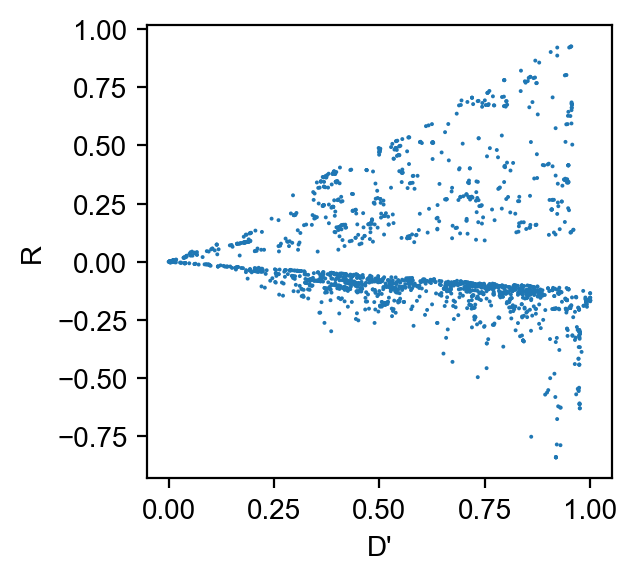

In [93]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(dprime, R, s=2, edgecolor='None')
ax.set_xlabel("D'")
ax.set_ylabel("R")


In [52]:
association_var_and_haplotype = pd.concat([dprime, R], axis=1)
association_var_and_haplotype.columns = ['Dprime', 'R']

In [53]:
association_var_and_haplotype.head()

,Dprime,R
"22:33870673[b37]C,G",0.490297,-0.205172
"22:33871533[b37]C,T",0.611067,-0.081961
"22:33872261[b37]T,C",0.444591,-0.099465
"22:33872468[b37]A,G",0.404796,-0.222312
"22:33872572[b37]T,C",0.438635,-0.096272


Variants from Pardis's paper - Nature 2007 - https://www.nature.com/articles/nature06250/tables/1

 - 24 rs1573662 LARGE conserved 5' UTR - 	NC_000022.10:g.34289111G>A
 - 24 rs5999077 LARGE conserved intron - NC_000022.11:g.33738123T>C
 - 24 rs1013337 LARGE conserved 5' UTR - NC_000022.10:g.34211302C>A

Grossman 2013 Cell
https://www.cell.com/fulltext/S0092-8674(13)00087-1#supplementaryMaterial
https://www.cell.com/cms/10.1016/j.cell.2013.01.035/attachment/cfb4c1bb-5809-4396-8ca1-8d77059a8063/mmc2.xlsx
hg18: chr22:32464093-32464109 --> hg19: chr22:34134093-34134109
Although notably it didn't come up in the genomewide scan

Genome-wide scans provide evidence for positive selection of genes implicated in Lassa fever
https://royalsocietypublishing.org/doi/full/10.1098/rstb.2011.0299

In [54]:
varind = info.loc[info['POS'].isin([34289111, 34134109, 34211302]), :].index
display(info.loc[info['POS'].isin([34289111, 34134109, 34211302]), :])

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
"22:34134109[b37]T,C",22,34134109,rs5999077,T,C,.,PASS,RefPanelAF=0.165153;AN=11110;AC=3710;INFO=0.99...
"22:34211302[b37]C,A",22,34211302,rs1013337,C,A,.,PASS,RefPanelAF=0.191283;AN=11110;AC=3795;INFO=0.99...
"22:34289111[b37]G,A",22,34289111,rs1573662,G,A,.,PASS,RefPanelAF=0.130448;AN=11110;AC=2908;INFO=0.96...


In [55]:
association_var_and_haplotype.loc[varind, :]

,Dprime,R
"22:34134109[b37]T,C",0.735479,0.530471
"22:34211302[b37]C,A",0.956873,0.674342
"22:34289111[b37]G,A",0.772588,0.671580


In [56]:
from pyliftover import LiftOver
lo = LiftOver('hg18', 'hg19')
print(lo.convert_coordinate('chr22', 32464093))
print(lo.convert_coordinate('chr22', 32464109))

[('chr22', 34134093, '+', 3320958047)]
[('chr22', 34134109, '+', 3320958047)]


In [57]:
tolook = [x for x in association_var_and_haplotype.index if ('34289111' in x) or ('33738123' in x) or ('34211302' in x)]
association_var_and_haplotype.loc[tolook,:]

,Dprime,R
"22:34211302[b37]C,A",0.956873,0.674342
"22:34289111[b37]G,A",0.772588,0.671580


In [58]:
pos = pd.Series(association_var_and_haplotype.index).apply(lambda x: x.split(':')[1].split('[')[0]).astype(int)
ind = (pos>=34134093) & (pos<=34134109)
association_var_and_haplotype.loc[ind.values, :]

,Dprime,R
"22:34134093[b37]G,A",0.735479,0.530471
"22:34134109[b37]T,C",0.735479,0.530471


In [59]:
hapstatus_merge = pd.merge(left=hapstatus, right=hapgenotype_calls[['Country', 'Array', 'Batch', 'Epoch']], left_on='Sample', right_index=True)
hapstatus_merge.head()

IDV_KMeans_Clustering                    Sample  \
WG0284565-DNA_A08_G-7030 1                      0  WG0284565-DNA_A08_G-7030   
                         2                      0  WG0284565-DNA_A08_G-7030   
WG0284565-DNA_A09_G-7022 1                      0  WG0284565-DNA_A09_G-7022   
                         2                      0  WG0284565-DNA_A09_G-7022   
WG0284565-DNA_B08_G-7260 1                      0  WG0284565-DNA_B08_G-7260   

                           Country Array Batch     Epoch  
WG0284565-DNA_A08_G-7030 1      SL    H3     1  Post2016  
                         2      SL    H3     1  Post2016  
WG0284565-DNA_A09_G-7022 1      SL    H3     1  Post2016  
                         2      SL    H3     1  Post2016  
WG0284565-DNA_B08_G-7260 1      SL    H3     1  Post2016

In [60]:
hapstatus_merge.groupby('Country')['IDV_KMeans_Clustering'].mean()

Country
NG    0.239362
SL    0.168838
Name: IDV_KMeans_Clustering, dtype: float64

In [61]:
kgfn = 'gs://popgen-gwas/data/metadata/PopgenPre2016/Popgen_1KG_Overlaps.tsv'
kg_info = pd.read_csv(kgfn, sep='\t')
kg_info.index = kg_info['IID']
kg_info.head()

,IID,1KG_ID,Relatedness_chr22,Pop,SampleType
IID,,,,,
Winter2013_F-NG-C-113C,Winter2013_F-NG-C-113C,HG02968,1.0061,ESN,TriosNG
Winter2013_F-SL-70C,Winter2013_F-SL-70C,"HG03469,HG03470","0.49924799999999997,0.509117","MSL,MSL",TriosSL
WG0284565-DNA_C12_G-7167,WG0284565-DNA_C12_G-7167,HG03069,1.0161200000000001,MSL,SuspectedLassaSL
Winter2013_F-SL-12F,Winter2013_F-SL-12F,HG03442,0.995732,MSL,TriosSL
Winter2013_F-NG-C-120M,Winter2013_F-NG-C-120M,HG03294,1.0335,ESN,TriosNG


In [62]:
kg_info['Pop'].value_counts()

ESN        132
MSL        128
ESN,ESN     41
MSL,MSL     13
Name: Pop, dtype: int64

In [63]:
hapstatus_merge['1KG_Pop'] = kg_info.loc[hapstatus_merge['Sample'], 'Pop'].values
hapstatus_merge['1KG_Pop'] = hapstatus_merge['1KG_Pop'].replace(np.nan, 'Not 1KG')
hapstatus_merge['1KG_ID'] = kg_info.loc[hapstatus_merge['Sample'], '1KG_ID'].values
hapstatus_merge['Relatedness_chr22'] = kg_info.loc[hapstatus_merge['Sample'], 'Relatedness_chr22'].values

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:947: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [64]:
hapstatus_merge.head()

IDV_KMeans_Clustering                    Sample  \
WG0284565-DNA_A08_G-7030 1                      0  WG0284565-DNA_A08_G-7030   
                         2                      0  WG0284565-DNA_A08_G-7030   
WG0284565-DNA_A09_G-7022 1                      0  WG0284565-DNA_A09_G-7022   
                         2                      0  WG0284565-DNA_A09_G-7022   
WG0284565-DNA_B08_G-7260 1                      0  WG0284565-DNA_B08_G-7260   

                           Country Array Batch     Epoch  1KG_Pop 1KG_ID  \
WG0284565-DNA_A08_G-7030 1      SL    H3     1  Post2016  Not 1KG    NaN   
                         2      SL    H3     1  Post2016  Not 1KG    NaN   
WG0284565-DNA_A09_G-7022 1      SL    H3     1  Post2016  Not 1KG    NaN   
                         2      SL    H3     1  Post2016  Not 1KG    NaN   
WG0284565-DNA_B08_G-7260 1      SL    H3     1  Post2016  Not 1KG    NaN   

                           Relatedness_chr22  
WG0284565-DNA_A08_G-7030 1               NaN  
                         2               NaN  
WG0284565-DNA_A09_G-7022 1               NaN  
                         2               NaN  
WG0284565-DNA_B08_G-7260 1               NaN

In [65]:
hapstatus_merge['1KG_Pop'].value_counts()

Not 1KG    4472
ESN         238
MSL         234
ESN,ESN      74
MSL,MSL      20
Name: 1KG_Pop, dtype: int64

In [71]:
association_var_and_haplotype = pd.merge(left=association_var_and_haplotype, right=info[['ID']], left_index=True, right_index=True, how='left')

In [72]:
hapgenotype_calls.to_csv('../../data/tmp/LARGE/LARGE_Haplotype_KMeans2_Genotype_Calls.tsv',sep='\t')
hapstatus_merge.to_csv('../../data/tmp/LARGE/LARGE_Haplotype_KMeans2_Allele_Calls.tsv',sep='\t')
association_var_and_haplotype.to_csv('../../data/tmp/LARGE/LARGE_Haplotype_Associated_Variants_Dprime_R.tsv', sep='\t')
! gsutil -m cp -R ../../data/tmp/LARGE gs://popgen-gwas/data/analysis/LARGE

Copying file://../../data/tmp/LARGE/LARGE_Haplotype_KMeans2_Allele_Calls.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/tmp/LARGE/LARGE_Haplotype_Associated_Variants_Dprime_R.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/tmp/LARGE/vcf/22.vcf.gz [Content-Type=text/vcard]...  
Copying file://../../data/tmp/LARGE/LARGE_Haplotype_KMeans2_Genotype_Calls.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/tmp/LARGE/vcf/22.33870000_to_34470000.maf_1e-2.clean.txt [Content-Type=text/plain]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any use

## Look at tag SNPs

In [73]:
search_dat = allele_calls_05_2.T.copy()
search_dat = search_dat.subtract(search_dat.mean(axis=0), axis=1)
search_dat = search_dat.div(search_dat.std(axis=0), axis=1)
search_dat.head()

,,"22:33870673[b37]C,G","22:33871533[b37]C,T","22:33872261[b37]T,C","22:33872468[b37]A,G","22:33872572[b37]T,C","22:33872863[b37]C,T","22:33873203[b37]A,G","22:33874033[b37]C,T","22:33874704[b37]A,C","22:33875161[b37]A,G",...,"22:34469226[b37]C,T","22:34469264[b37]A,G","22:34469271[b37]A,G","22:34469292[b37]C,T","22:34469332[b37]T,C","22:34469348[b37]G,A","22:34469447[b37]T,C","22:34469564[b37]G,A","22:34469674[b37]G,C","22:34469959[b37]A,G"
WG0284565-DNA_A08_G-7030,1,-0.802910,-0.257352,-0.429256,-1.053745,-0.421121,-0.412923,-0.258228,-0.412923,-0.471358,-0.825154,...,-0.22992,-0.268992,-0.268992,0.532457,-0.586002,-0.588753,-0.572557,-0.295236,-0.374576,1.785282
WG0284565-DNA_A09_G-7022,1,-0.802910,-0.257352,-0.429256,0.948808,-0.421121,-0.412923,-0.258228,-0.412923,-0.471358,-0.825154,...,-0.22992,-0.268992,-0.268992,-1.877713,-0.586002,-0.588753,-0.572557,-0.295236,-0.374576,-0.560024
WG0284565-DNA_B08_G-7260,1,1.245222,-0.257352,-0.429256,0.948808,-0.421121,-0.412923,-0.258228,-0.412923,-0.471358,1.211654,...,-0.22992,-0.268992,-0.268992,0.532457,-0.586002,-0.588753,-0.572557,-0.295236,2.669156,-0.560024
WG0284565-DNA_B10_G-7140,1,-0.802910,-0.257352,-0.429256,-1.053745,-0.421121,-0.412923,-0.258228,-0.412923,-0.471358,-0.825154,...,-0.22992,-0.268992,-0.268992,-1.877713,-0.586002,-0.588753,-0.572557,-0.295236,-0.374576,-0.560024
WG0284565-DNA_E08_G-6835,1,1.245222,-0.257352,2.329151,0.948808,2.374145,2.421280,-0.258228,2.421280,2.121110,1.211654,...,-0.22992,-0.268992,-0.268992,0.532457,1.706140,1.698168,1.746206,-0.295236,-0.374576,-0.560024


In [74]:
hapval = hapstatus_merge['IDV_KMeans_Clustering'] - hapstatus_merge['IDV_KMeans_Clustering'].mean()
hapval = hapval / hapval.std()

In [75]:
R = search_dat.T.dot(hapval) / (search_dat.shape[0]-1)

In [76]:
R.abs().sort_values(ascending=False).head(30)

22:34172398[b37]A,C    0.925261
22:34174184[b37]T,C    0.924667
22:34190795[b37]T,C    0.922242
22:34211867[b37]C,T    0.920445
22:34193656[b37]T,G    0.920313
22:34225513[b37]G,A    0.901082
22:34227065[b37]C,T    0.885872
22:34240637[b37]G,A    0.864201
22:34254648[b37]G,A    0.855707
22:34153445[b37]C,G    0.841121
22:34153779[b37]T,C    0.840180
22:34153853[b37]T,C    0.840180
22:34153854[b37]A,G    0.840180
22:34154229[b37]C,T    0.839241
22:34275257[b37]T,C    0.821048
22:34194680[b37]C,A    0.802329
22:34171560[b37]G,A    0.802070
22:34169938[b37]T,C    0.800725
22:34248633[b37]G,A    0.794472
22:34249129[b37]C,T    0.794472
22:34238465[b37]G,C    0.791497
22:34251476[b37]G,C    0.790144
22:34238131[b37]C,T    0.789034
22:34156544[b37]G,A    0.788319
22:34153047[b37]C,T    0.785228
22:34229404[b37]A,G    0.780510
22:34230571[b37]A,G    0.780510
22:34228573[b37]G,A    0.780008
22:34227278[b37]A,G    0.780008
22:34257878[b37]G,T    0.776218
dtype: float64

In [77]:
display(info['ID'].isin(['rs59015613', 'rs16993014', 'rs4525791', 'rs59594190', 'rs8135517']).value_counts())
ind = info.index[info['ID'].isin(['rs59015613', 'rs16993014', 'rs4525791', 'rs59594190', 'rs8135517'])]

False    3425
True        5
Name: ID, dtype: int64

In [78]:
tag_snps = allele_calls_05_2.loc[ind, :].T

In [79]:
thresh = 1
ct = pd.crosstab(tag_snps.sum(axis=1)>=thresh, hapstatus_merge['IDV_KMeans_Clustering'])
print('Sensitivity %.2f' % (ct.loc[True, 1] / ct[1].sum()))
print('Specificity %.2f' % (ct.loc[False, 0] / ct.loc[:,0].sum()))

Sensitivity 0.94
Specificity 0.98


In [80]:
thresh = 2
ct = pd.crosstab(tag_snps.sum(axis=1)>=thresh, hapstatus_merge['IDV_KMeans_Clustering'])
print('Sensitivity %.2f' % (ct.loc[True, 1] / ct[1].sum()))
print('Specificity %.2f' % (ct.loc[False, 0] / ct.loc[:,0].sum()))

Sensitivity 0.92
Specificity 0.99


In [81]:
thresh = 3
ct = pd.crosstab(tag_snps.sum(axis=1)>=thresh, hapstatus_merge['IDV_KMeans_Clustering'])
print('Sensitivity %.2f' % (ct.loc[True, 1] / ct[1].sum()))
print('Specificity %.2f' % (ct.loc[False, 0] / ct.loc[:,0].sum()))

Sensitivity 0.92
Specificity 0.99
